In [3]:
# load python packages for data processing and analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import nltk
from nltk import pos_tag
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

Exploratory steps

In [19]:
# load the data
mma_mart = pd.read_csv('mma_mart.csv')

The dataset has about 987K rows. Since we have about 98K unique orders, on average each order contains about 10 products. We have about 35K unique products, and they are from 134 aisles, and 21 departments.

You perhaps want to do more exploratory data analysis (EDA), but I will move on to pick 1000 products for the special Instabasket aisle.

In [8]:
#average number of aisles per order
aisle_per_order = mma_mart.groupby('order_id')['aisle_id', 'department_id', 'product_name'].nunique().reset_index()

/tmp/ipykernel_1017/3782090744.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  aisle_per_order = mma_mart.groupby('order_id')['aisle_id', 'department_id', 'product_name'].nunique().reset_index()


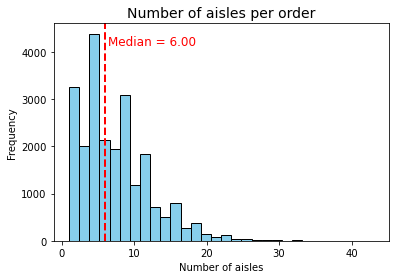

In [7]:
median_aisle = np.median(aisle_per_order['aisle_id'])
plt.hist(aisle_per_order['aisle_id'], bins=30, color='skyblue', edgecolor='black')

plt.axvline(median_aisle, color='red', linestyle='dashed', 
                      linewidth=2, label=f'Median = {median_aisle:.2f}')

plt.title('Number of aisles per order', fontsize = 14)
plt.text(median_aisle+6.5, plt.gca().get_ylim()[1]*0.9, 
         f'Median = {median_aisle:.2f}', color='red', fontsize=12, ha='center')

# Labeling axes
plt.xlabel('Number of aisles')
plt.ylabel('Frequency')

# Show the histogram
plt.show()

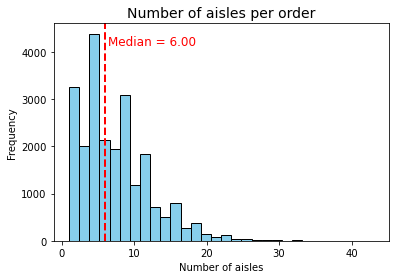

In [9]:
avg_product = np.median(aisle_per_order['product_name'])
plt.hist(aisle_per_order['aisle_id'], bins=30, color='skyblue', edgecolor='black')

plt.axvline(median_aisle, color='red', linestyle='dashed', 
                      linewidth=2, label=f'Median = {median_aisle:.2f}')

plt.title('Number of aisles per order', fontsize = 14)
plt.text(median_aisle+6.5, plt.gca().get_ylim()[1]*0.9, 
         f'Median = {median_aisle:.2f}', color='red', fontsize=12, ha='center')

# Labeling axes
plt.xlabel('Number of aisles')
plt.ylabel('Frequency')

# Show the histogram
plt.show()

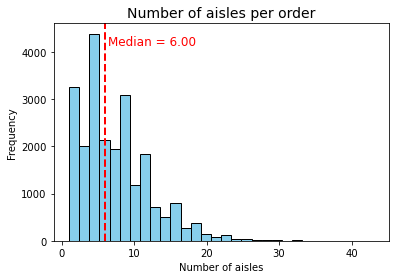

In [11]:
median_aisle = np.median(aisle_per_order['aisle_id'])
plt.hist(aisle_per_order['aisle_id'], bins=30, color='skyblue', edgecolor='black')

plt.axvline(median_aisle, color='red', linestyle='dashed', 
                      linewidth=2, label=f'Median = {median_aisle:.2f}')

plt.title('Number of aisles per order', fontsize = 14)
plt.text(median_aisle+6.5, plt.gca().get_ylim()[1]*0.9, 
         f'Median = {median_aisle:.2f}', color='red', fontsize=12, ha='center')

# Labeling axes
plt.xlabel('Number of aisles')
plt.ylabel('Frequency')

# Show the histogram
plt.show()

In [16]:
avg_aisle_per_product = np.average(aisle_per_order['aisle_id']/aisle_per_order['product_name'])
print('Average number of aisles travel for each product is:', round(avg_aisle_per_product, 2), ';\n')
max_aisle_per_order = np.max(aisle_per_order['aisle_id'])
print('Max number of aisles travel for one order is:', round(max_aisle_per_order, 2), ';\n')

Average number of aisles travel for each product is: 0.79 ;

Max number of aisles travel for one order is: 43 ;



In [18]:
mma_mart['aisle'].value_counts().to_csv('mma_aisle.csv')

In [20]:
mma_mart['department'].value_counts()

produce            67240
dairy eggs         38817
snacks             21039
beverages          19200
frozen             16181
pantry             13467
bakery              8381
canned goods        7704
deli                7572
dry goods pasta     6041
household           5237
breakfast           5188
meat seafood        5077
personal care       3302
babies              3149
international       1963
alcohol             1064
pets                 773
missing              545
bulk                 279
other                276
Name: department, dtype: int64

In [21]:
# add tokens into df
#remove non-aplphabets (here I remove numbers as well but it is debatable
mma_mart_plus = mma_mart.drop_duplicates(subset = 'product_id').reset_index()
product = mma_mart_plus['product_name']
product_tokens = [x.split(' ') for x in product]

mma_mart_plus['product_tokens'] = product_tokens

In [26]:
# Flatten the list of lists
flat_data = [word for sublist in mma_mart_plus['product_tokens'] for word in sublist]

# Use Counter to count word occurrences
word_counts = Counter(flat_data)

# Find the most common word
most_common_words = word_counts.most_common(10)

# Print the most frequent word and its frequency
for word, frequency in most_common_words:
    print(f'{word}: {frequency}')

Organic: 3014
&: 2220
Chocolate: 1177
Cheese: 1080
Free: 957
Original: 770
Chicken: 735
Yogurt: 655
Milk: 652
Cream: 620


In [28]:
# remove stop words
nltk.download('stopwords')  # Download the stopwords data

from nltk.corpus import stopwords

# Get the English stopwords from NLTK
stop_words = set(stopwords.words('english', 'french'))

# Remove stopwords from the list
filtered_word_list = {word: count for word, count in word_counts.items() if word not in stop_words}

# Find the most common word
filtered_most_common_words = Counter(filtered_word_list).most_common(10)

# Print the most frequent word and its frequency
for word, frequency in filtered_most_common_words:
    print(f'{word}: {frequency}')

Organic: 3014
&: 2220
Chocolate: 1177
Cheese: 1080
Free: 957
Original: 770
Chicken: 735
Yogurt: 655
Milk: 652
Cream: 620


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/d5c92d13-5578-434b-a7a0-23780c3ca393/nltk_data..
[nltk_data]     .
[nltk_data]   Package stopwords is already up-to-date!


In [30]:
# remove words that are not noun
nltk.download('averaged_perceptron_tagger')  # Download the POS tagger data

def is_noun(word):
    pos_tags = pos_tag([word])
    return any(tag.startswith('N') for word, tag in pos_tags)

nouns_dict = {word: count for word, count in filtered_word_list.items() if is_noun(word)}

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/d5c92d13-5578-434b-a7a0-23780c3ca393/nltk_data..
[nltk_data]     .
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [32]:
cleaned_word_list = []

for key in nouns_dict:
    cleaned_word_list.append(key)

In [34]:
import inflect
import re

def alphabet(word):
    output = re.sub(r'[^a-zA-Z]', '', word)
    return (output)

# Create a new DataFrame with specified words removed
filtered_product = mma_mart_plus['product_tokens'].apply(
    lambda words: [alphabet(word) for word in words 
                   if ((word in cleaned_word_list) and
                       (len(word) >= 2))])

# Display the filtered DataFrame
print(filtered_product)

0                                            [Yogurt]
1                  [Milk, Fat, Milk, Cottage, Cheese]
2                                    [Celery, Hearts]
3                                   [Cucumber, Kirby]
4                                     [Sardines, Oil]
                             ...                     
22772                 [Chocolate, Mint, Candy, Canes]
22773                            [Breakfast, Sausage]
22774             [Chicken, Noodle, Vegetables, Soup]
22775    [Stick, Cherry, Pineapple, Swirl, Ice, Pops]
22776         [PODS, Scent, Pacs, Laundry, Detergent]
Name: product_tokens, Length: 22777, dtype: object


In [41]:
import inflect

# Initialize the inflect engine
p = inflect.engine()

# List of words with potential plurals
singular_product = [0]*len(filtered_product)

# Function to convert plural form to singular form
def plural_to_singular(word):
    if len(word) >= 2:
        singular = p.singular_noun(word)
    else: singular = False
    return singular if singular else word  # If singular form not found, return the original word

# Identify and convert plural forms to singular forms
for i in range(0, len(filtered_product)):
    current_word_list = filtered_product[i]
    singular_words = [plural_to_singular(word) for word in current_word_list]
    singular_product[i] = singular_words

In [46]:
mma_mart_plus['token_for_use'] = singular_product

In [48]:
product_name_for_use = [' '.join(x) for x in singular_product]

In [50]:
mma_mart_plus['product_name_for_use'] = product_name_for_use

In [55]:
mma_mart_plus.to_csv('mma_mart(with tokens).csv')

Jaccard similarity <br>
Here I assume that substitutes can only be obtained from the same department

In [62]:
df = mma_mart_plus

In [70]:
# Function to calculate Jaccard similarity between two sets
def jaccard_similarity(set1, set2):
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    return intersection / union if union > 0 else 0

In [118]:
def find_substitute(target_product_id):
    target_product = pd.DataFrame(df[df['product_id'] == target_product_id].reset_index())
    target_department = target_product['department_id'][0]
    department_product = df[df['department_id'] == target_department].reset_index()
    list1 = target_product['token_for_use'][0]
    similarities = [0]*len(department_product)
    
    for i in range(0, len(department_product)):
        list2 = department_product['token_for_use'][i]
        similarity = jaccard_similarity(set(list1), set(list2))
        similarities[i] = similarity
        
    output = pd.DataFrame(department_product)
    output['similarity'] = similarities
    
    return(output)

In [124]:
sub11109 = find_substitute(11109)
sub11109[sub11109['similarity'] >= 0.75]

,level_0,index,order_id,product_id,product_name,aisle_id,aisle,department_id,department,product_tokens,token_for_use,product_name_for_use,similarity
1,1,1,1,11109,Organic 4% Milk Fat Whole Milk Cottage Cheese,108.0,other creams cheeses,16.0,dairy eggs,"[Organic, 4%, Milk, Fat, Whole, Milk, Cottage,...","[Milk, Fat, Milk, Cottage, Cheese]",Milk Fat Milk Cottage Cheese,1.00
158,923,1171,120,1503,Low Fat Cottage Cheese,108.0,other creams cheeses,16.0,dairy eggs,"[Low, Fat, Cottage, Cheese]","[Fat, Cottage, Cheese]",Fat Cottage Cheese,0.75
334,2120,3319,338,11689,On the Go Low Fat Cottage Cheese,108.0,other creams cheeses,16.0,dairy eggs,"[On, the, Go, Low, Fat, Cottage, Cheese]","[Fat, Cottage, Cheese]",Fat Cottage Cheese,0.75
450,3121,5757,585,35234,2% Low Fat Cottage Cheese,108.0,other creams cheeses,16.0,dairy eggs,"[2%, Low, Fat, Cottage, Cheese]","[Fat, Cottage, Cheese]",Fat Cottage Cheese,0.75
467,3209,6009,608,42307,Organic Reduced Fat 2% Cottage Cheese,108.0,other creams cheeses,16.0,dairy eggs,"[Organic, Reduced, Fat, 2%, Cottage, Cheese]","[Fat, Cottage, Cheese]",Fat Cottage Cheese,0.75
613,4355,9394,949,38558,Organic Low Fat Cottage Cheese,108.0,other creams cheeses,16.0,dairy eggs,"[Organic, Low, Fat, Cottage, Cheese]","[Fat, Cottage, Cheese]",Fat Cottage Cheese,0.75
759,5385,13187,1328,46787,Fat Free Cottage Cheese,108.0,other creams cheeses,16.0,dairy eggs,"[Fat, Free, Cottage, Cheese]","[Fat, Cottage, Cheese]",Fat Cottage Cheese,0.75
898,6837,19282,1975,28420,Organic Cultured Low Fat 1% Cottage Cheese,108.0,other creams cheeses,16.0,dairy eggs,"[Organic, Cultured, Low, Fat, 1%, Cottage, Che...","[Fat, Cottage, Cheese]",Fat Cottage Cheese,0.75
1134,8866,30082,3022,27581,Reduced Fat 2% Milk 4 Cheese Italian Cheese Sh...,21.0,packaged cheese,16.0,dairy eggs,"[Reduced, Fat, 2%, Milk, 4, Cheese, Italian, C...","[Fat, Milk, Cheese, Cheese]",Fat Milk Cheese Cheese,0.75
1160,9219,32165,3228,11090,Organic Fat Free Cottage Cheese,21.0,packaged cheese,16.0,dairy eggs,"[Organic, Fat, Free, Cottage, Cheese]","[Fat, Cottage, Cheese]",Fat Cottage Cheese,0.75
